# L'influenza della distribuzione a priori {#sec-prior-influence}

**Prerequisiti**

- Leggere il capitolo 4 "Balance and Sequentiality in Bayesian Analyses" di *Bayes rules!* [@Johnson2022bayesrules].

**Concetti e competenze chiave**

- Prior non informativi, debolmente informativi, informativi.
- Prior di Jeffreys.
- Prior e cambiamenti di scala.
- Prior coniugati.
- Analisi di sensibilità.

**Preparazione del Notebook**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
import pymc as pm
import pymc.sampling_jax
import requests
import arviz as az
from scipy.stats import norm, t

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "balance_prior_posterior"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione {.unnumbered}

Consideriamo un semplice scenario medico: un paziente si presenta dal dottore con un mal di testa. Il medico, per formulare una diagnosi accurata, dovrà considerare diversi fattori. Possiamo immaginare due medici con approcci leggermente differenti:

* **Medico 1:** Si basa principalmente sui risultati di test specifici, senza considerare una storia clinica pregressa del paziente.
* **Medico 2:** Oltre ai test, tiene conto della storia clinica del paziente, cercando di individuare eventuali fattori di rischio o condizioni preesistenti che potrebbero essere correlate al mal di testa.

Quale dei due medici è in grado di fornire una diagnosi più precisa? La risposta risiede nel concetto di *probabilità a priori* (o semplicemente *prior*), ovvero le credenze che un individuo ha su un evento prima di osservare nuovi dati.

Nel contesto medico, la storia clinica del paziente rappresenta una preziosa fonte di informazioni a priori. Conoscere gli antecedenti sanitari di un individuo permette al medico di formulare ipotesi più plausibili sulla causa del mal di testa. In termini bayesiani, i priori agiscono come una sorta di "lente" attraverso cui vengono interpretati i nuovi dati (in questo caso, i risultati dei test).

Quando prendiamo decisioni nella vita quotidiana, utilizziamo costantemente le nostre conoscenze pregresse per interpretare nuove informazioni. Ad esempio, se vediamo una persona che indossa un camice bianco in un ospedale, inferiamo che si tratti di un medico, basandoci sulla nostra esperienza e sulle associazioni mentali che abbiamo costruito nel tempo. Questo processo di inferenza è molto simile a quello che avviene nell'aggiornamento bayesiano.

La scelta dei priori ha un impatto fondamentale sulla qualità delle inferenze che possiamo trarre dai dati. Questo capitolo si focalizza sull'importanza e sulle implicazioni che derivano dalla scelta dei priori sul processo di aggiornamento bayesiano. Per illustrare questi concetti, esamineremo alcuni esempi discussi da @Johnson2022bayesrules. 

## La Distribuzione a Priori

La distribuzione a priori gioca un ruolo centrale nell'approccio bayesiano, poiché rappresenta le nostre conoscenze pregresse o le ipotesi sui parametri del modello prima di osservare i dati. Questo concetto è fondamentale perché permette di integrare le informazioni disponibili in precedenza con i dati osservati, fornendo così una stima più precisa e robusta dei parametri. Le distribuzioni a priori possono variare a seconda del grado di certezza che si attribuisce ai valori dei parametri.

## Tipologie di Distribuzioni a Priori

La scelta della distribuzione a priori (nota come *elicitazione della prior*) è uno dei passaggi cruciali nell'analisi bayesiana ed è spesso vista come la fase più controversa, poiché è considerata "soggettiva". Tuttavia, è importante sottolineare che la scelta della prior non è necessariamente soggettiva. A differenza dell'approccio frequentista, l'approccio bayesiano incoraggia la raccolta e l'integrazione di tutte le informazioni conosciute sul parametro in anticipo. Questo può essere fatto in modo *oggettivo*, basandosi su evidenze pregresse o raccomandazioni consolidate.

Esistono tre principali categorie di distribuzioni a priori.

1. **Distribuzioni a Priori Non Informative.** Le distribuzioni a priori non informative sono caratterizzate da una totale mancanza di conoscenza pregressa e assegnano la stessa credibilità a tutti i valori dei parametri. Un esempio comune di distribuzione a priori non informativa è la distribuzione uniforme, basata sul "Principio della Ragione Insufficiente" formulato da Laplace. Secondo questo principio, in assenza di evidenze rilevanti pregresse, tutte le possibili configurazioni dei parametri sono considerate equiprobabili. 

2. **Distribuzioni a Priori Debolmente Informative.** Le distribuzioni a priori debolmente informative consentendo di integrare una quantità limitata di informazioni pregresse nei modelli statistici. Queste distribuzioni sono progettate per riflettere le nostre assunzioni su quali possono essere i valori "ragionevoli" dei parametri del modello, tenendo conto delle incertezze presenti nell'analisi. L'uso di informazioni a priori debolmente informative può contribuire a migliorare la stabilità dell'analisi senza influenzare in modo significativo le conclusioni derivate da essa.

   Le distribuzioni a priori debolmente informative hanno la caratteristica di non "spostare" in modo significativo la distribuzione a posteriori in una direzione specifica. In altre parole, sono centrate su valori "neutri" dei parametri. Ad esempio, quando si trattano parametri che possono assumere valori positivi o negativi, la distribuzione a priori debolmente informativa potrebbe essere centrata sullo zero. Nel caso di parametri che rappresentano proporzioni, essa potrebbe essere centrata su 0.5.

   Tuttavia, ciò che rende queste distribuzioni debolmente informative è la specifica definizione di un intervallo "plausibile" di valori dei parametri. Questo intervallo indica quali valori dei parametri sono considerati plausibili e quali sono invece considerati implausibili. Ad esempio, una distribuzione a priori debolmente informativa potrebbe suggerire che valori estremamente grandi o estremamente bassi dei parametri sono poco plausibili, concentrandosi su un intervallo più stretto di valori considerati ragionevoli.

   In sintesi, le distribuzioni a priori debolmente informative sono utilizzate per incorporare informazioni pregresse limitate nei modelli bayesiani, contribuendo a stabilizzare le stime dei parametri senza influenzare in modo significativo le conclusioni derivate dai dati. Queste distribuzioni definiscono un intervallo plausibile di valori dei parametri, aiutando a guidare l'analisi verso soluzioni più verosimili senza imporre vincoli eccessivi sui risultati.

3. **Distribuzioni a Priori Informativa.** Le conoscenze pregresse, acquisite attraverso ricerche precedenti, pareri esperti o una combinazione di entrambi, possono essere meticolosamente integrate nel processo di analisi mediante l'incorporazione nelle distribuzioni a priori. Queste distribuzioni sono comunemente conosciute come distribuzioni a priori informative. Esse rappresentano un mezzo per codificare in modo sistematico informazioni concrete e rilevanti che possono avere un notevole impatto sull'analisi statistica, fornendo una solida base di conoscenza su cui fondare l'inferenza bayesiana. 

   Le distribuzioni a priori informative possono derivare da una vasta gamma di fonti, comprese ricerche pregresse, pareri di esperti nel campo e altre fonti affidabili. Questo approccio offre un metodo strutturato per integrare in modo coerente le conoscenze pregresse nel processo di analisi statistica. L'incorporazione di queste informazioni aggiuntive contribuisce notevolmente a migliorare la robustezza e l'accuratezza delle conclusioni derivate dai dati, fornendo una solida base empirica su cui basare le stime dei parametri del modello e le decisioni basate sull'analisi bayesiana.

   Nell'ambito della ricerca psicologica, l'utilizzo di distribuzioni a priori informative è attualmente poco diffuso, tuttavia emergono segnali che all'interno della comunità statistica sta crescendo l'interesse per questa pratica, considerandola come un avanzamento promettente nel campo della data science.

## L'importanza della Prior in base ai Dati

Un aspetto cruciale da considerare è che l'influenza della prior diminuisce all'aumentare del numero di dati osservati. In altre parole, *con un numero infinito di dati*, la verosimiglianza diventa estremamente precisa (o "affilata"), rendendo la scelta della prior irrilevante, a patto che la prior non assegni probabilità zero a regioni dello spazio parametri dove la verosimiglianza è positiva. 

Tuttavia, la prior assume un'importanza fondamentale quando si lavora con *dataset di piccole dimensioni*. In questi casi, la distribuzione a priori può avere un'influenza significativa sulle stime, poiché i dati da soli non sono sufficienti per ottenere stime precise.

## Effetti del Cambiamento di Scala dei Parametri

Un altro aspetto da tenere a mente è che le priors possono cambiare quando si modificano le scale dei parametri. Se un parametro viene riscalato, ad esempio passando da metri a chilometri, anche la prior deve essere riscalata di conseguenza per mantenere la coerenza dell'inferenza.

### Scala e invariabilità della scelta delle distribuzioni a priori

La scelta delle distribuzioni a priori non informative non è sempre banale e non può sempre essere rappresentata da una prior piatta. Per capire questo concetto, è fondamentale comprendere il ruolo della *scala*. Vediamo un esempio per chiarire meglio questo aspetto.

Immaginiamo di avere un dataset che contiene la media dei diametri di alcuni alberi, e vogliamo stimare la media di questi diametri utilizzando un metodo bayesiano. Prima di osservare i dati, dobbiamo specificare la nostra distribuzione a priori, poiché non vogliamo che i dati influenzino la nostra scelta. Supponiamo di scegliere una distribuzione a priori piatta tra 1 cm e 10 cm, per evitare di introdurre bias:

```plaintext
import numpy as np

valori = np.arange(1, 6)  # Crea un array NumPy da 1 a 5
pesoPrior = np.full(5, 1/5)  # Crea un array NumPy di 5 elementi, tutti uguali a 1/5
```

In questo caso, stiamo assegnando la stessa probabilità a ciascun diametro compreso tra 1 e 10 cm, senza dare più peso a un valore rispetto a un altro. Questa sembra una scelta ragionevole e "non informativa", poiché non stiamo preferendo nessun diametro in particolare.

Ora, supponiamo di voler modificare leggermente la nostra analisi e di misurare la grandezza degli alberi in termini di *area basale* (cioè la sezione trasversale dell'albero alla base), che è proporzionale al quadrato del diametro (cioè $x^2$). Poiché abbiamo già specificato la nostra distribuzione a priori in termini di diametro, dovremmo trasformare questa distribuzione in modo coerente con la nuova scala (area basale).

Il problema che emerge è il seguente: quando riscaliamo l'asse $x$ per riflettere l'area basale (cioè, passiamo da cm a cm²), i valori più grandi diventano più ampi (poiché l'area cresce con il quadrato del diametro), mentre i valori più piccoli diventano più stretti. Se vogliamo mantenere la stessa distribuzione a priori in termini di probabilità, dobbiamo modificare il peso di ciascun valore.

Di conseguenza, una distribuzione a priori che inizialmente era piatta (uguale per tutti i valori di diametro) non rimane piatta dopo la trasformazione in area basale. I valori più grandi ora hanno un peso minore, mentre i valori più piccoli hanno un peso maggiore. Questo dimostra che *una distribuzione a priori non può essere piatta per tutte le possibili trasformazioni dei parametri*.

### Il concetto di invariabilità della scala

Una delle chiavi per definire correttamente le distribuzioni a priori non informative è l'invariabilità rispetto alle trasformazioni dei parametri. Se possiamo scegliere liberamente come rappresentare i parametri (ad esempio, in termini di diametro o area basale), la nostra distribuzione a priori dovrebbe essere definita in modo che sia coerente indipendentemente dalla scala scelta. 

### Attenzione alle trasformazioni dei parametri

Un secondo messaggio importante riguarda la *cautela nelle trasformazioni dei parametri* nell'analisi bayesiana. Quando cambiamo i parametri del nostro modello, non stiamo semplicemente osservando un singolo valore, ma una distribuzione intera. La forma di questa distribuzione può cambiare notevolmente con la trasformazione dei parametri. 

Ad esempio, se si sta conducendo uno studio psicologico e si vuole misurare un parametro legato alla gravità di un disturbo (ad esempio, la gravità della depressione su una scala numerica), e poi si decide di trasformare la scala in un'unità diversa (ad esempio, un punteggio quadratico per evidenziare differenze estreme), la distribuzione a priori che sembrava ragionevole prima della trasformazione potrebbe non esserlo più dopo. Questo significa che bisogna prestare attenzione a come si scelgono le priors e come queste si comportano sotto diverse rappresentazioni del problema.

In conclusione, la scelta delle distribuzioni a priori non può essere fatta superficialmente. Deve essere considerata con attenzione, tenendo conto delle possibili trasformazioni dei parametri e assicurandosi che le priors siano coerenti rispetto alla scala scelta. Questo rende evidente che le priors non informative non sono sempre piatte, e la loro scelta deve tenere conto della struttura del problema e delle variabili coinvolte.

## Scelte predefinite per le distribuzioni a priori non informative

Una delle domande più ricorrenti nell'inferenza bayesiana riguarda la scelta delle *distribuzioni a priori non informative*. La risposta, però, è piuttosto complessa: non esiste una soluzione generalmente accettata. Questo è particolarmente importante perché, mentre le priors informative possono essere basate su conoscenze pregresse, una prior non informativa deve essere scelta con cura per evitare di influenzare eccessivamente i risultati.

Una delle proposte più famose, che soddisfa molte delle proprietà desiderabili, è la *prior di Jeffreys*, definita come:

$$ 
p(\phi) \propto \sqrt{ \det (F(\phi)) }, 
$$

dove $F(\phi)$ è la *matrice di informazione di Fisher*, che misura quanto la verosimiglianza cambia quando variano i parametri. La prior di Jeffreys ha due caratteristiche fondamentali:

1. **Invarianza rispetto alla riscalatura dei parametri**: Ciò significa che se trasformiamo la scala del parametro, la prior si adatta automaticamente, rimanendo coerente con il problema.
2. **Proporzionalità all'influenza dei parametri sulla verosimiglianza**: Parametri che influenzano maggiormente la verosimiglianza hanno una prior più informativa.

Questi aspetti sembrano coprire molti dei criteri comunemente accettati per la scelta delle distribuzioni a priori non informative. Tuttavia, la prior di Jeffreys presenta alcuni problemi nei modelli multivariati e gerarchici, il che limita la sua applicabilità come soluzione universale. 

### Scelte predefinite comuni per le priors non informative

Nonostante le difficoltà legate alla prior di Jeffreys, sono emerse alcune scelte predefinite comuni per le priors non informative, basate su intuizioni derivanti proprio da questa distribuzione. Di seguito sono elencate alcune di queste scelte:

1. **Parametri di scala (es. coefficiente angolare o intercetta in una regressione)**:
   - Per i parametri di scala, che influenzano l'output in modo lineare, si utilizzano comunemente priors piatte o quasi piatte. Queste possono essere distribuzioni uniformi con limiti fissati o, più comunemente, una *distribuzione normale ampia*.
   - Un esempio di prior modificata è l'uso di una normalità centrata su un valore neutro, come 0, per ottenere l'analogo bayesiano della regressione Lasso o Ridge, che introduce una penalizzazione sui parametri (Park & Casella, 2008; Kyung et al., 2010). 
     - Se questa penalizzazione è lieve, si parla di *priors debolmente regolarizzanti*.
     - Se è forte, si parla di *priors di riduzione (shrinkage)*, che possono essere fisse o adattative:
       - **Shrinkage fisso**: la forza della riduzione (ad es. controllata dalla deviazione standard nella prior normale) rimane costante.
       - **Shrinkage adattativo**: la prior di riduzione si adatta tramite un iperparametro (hyperprior), il che consente al modello di decidere autonomamente la forza della riduzione.

2. **Parametri di varianza (es. la deviazione standard in una regressione lineare)**:
   - Per i parametri di varianza, si utilizzano spesso priors che *decrescono all'aumentare del valore*. Un esempio classico è la prior di Jeffrey’s, che per la varianza assume la forma $1/x$, oppure la *distribuzione inversa-gamma*, molto comune per via della sua proprietà di coniugazione, che semplifica il calcolo bayesiano.

3. **Iperparametri di varianza nei modelli gerarchici**:
   - Nei modelli gerarchici, gli iperparametri di varianza vengono trattati con priors decrescenti come l'*inversa-gamma* o la *distribuzione half-t* [@gelman2006prior]. Queste priors sono progettate per gestire la varianza tra gruppi in modo efficace.

4. **Distribuzioni binomiali**:
   - Per una distribuzione binomiale, la prior di Jeffreys corrisponde a una distribuzione *Beta(1/2, 1/2)*, che è considerata una buona scelta predefinita non informativa. Questo tipo di prior assegna un peso equo alle possibili probabilità di successo, riflettendo una distribuzione equilibrata senza favorire un particolare risultato.

### Attenzione alle trasformazioni dei parametri

Un aspetto importante da considerare nell'uso delle priors non informative è che la loro forma può cambiare significativamente in seguito a trasformazioni dei parametri. Per esempio, passando dalla scala lineare alla scala quadratica di un parametro, la prior può assumere una forma diversa e introdurre involontariamente un bias. Pertanto, è essenziale prestare attenzione a come i parametri sono scalati e trasformati nel modello.

### Analisi di sensibilità

Infine, quando si è incerti sulla scelta della prior, un buon approccio consiste nel condurre un'*analisi di sensibilità*. Questa tecnica prevede di variare la prior e osservare come ciò influenzi i risultati. Se i risultati sono robusti rispetto a diverse scelte di prior, ciò suggerisce che la prior scelta non sta influenzando in modo eccessivo l'inferenza finale. Questo è particolarmente utile nei casi in cui si dispone di pochi dati, situazione in cui la prior può avere un impatto maggiore.

## Priori coniugate

Una distribuzione a priori è detta *coniugata* rispetto a una funzione di verosimiglianza se la distribuzione a posteriori risultante ha la stessa forma funzionale della distribuzione a priori. In altre parole, la distribuzione a priori e quella a posteriori appartengono alla stessa famiglia di distribuzioni. Questo è particolarmente utile perché, quando si usano *priori coniugate*, si ottiene una distribuzione a posteriori che può essere espressa in forma chiusa, rendendo possibile risolverla analiticamente.

Un esempio tipico è quello delle funzioni di verosimiglianza appartenenti alla *famiglia esponenziale*, per le quali esiste sempre una distribuzione a priori coniugata. Questo è uno dei motivi per cui le distribuzioni della famiglia esponenziale sono così rilevanti: in modelli semplici, l'uso di una prior coniugata consente di ottenere una soluzione analitica per la distribuzione a posteriori, noto come *modello coniugato-esponenziale*.

Tradizionalmente, si preferiva specificare priori coniugate quando possibile, proprio per la semplicità analitica che garantivano. Tuttavia, l'importanza delle priors coniugate è diminuita con l'evoluzione dei metodi di campionamento. Oggi, la maggior parte dei campionatori moderni (come i metodi MCMC) non richiede più la coniugazione per funzionare in modo efficiente, e l'uso di priors non coniugate è diventato comune senza compromettere la qualità delle stime.

## Simulazioni

In questa sezione, esploriamo come le distribuzioni a priori influenzano la distribuzione a posteriori attraverso una serie di simulazioni. La formula di Bayes, $p(\theta \mid y) \propto p(\theta) \times p(y \mid \theta)$, evidenzia come la distribuzione a posteriori sia il risultato della combinazione tra la distribuzione a priori e la funzione di verosimiglianza basata sui dati osservati. Se abbiamo le valutazioni puntuali della verosimiglianza e della distribuzione a priori, possiamo moltiplicarle punto per punto per ottenere la distribuzione a posteriori.

Consideriamo il caso in cui la verosimiglianza sia binomiale. Iniziamo con un caso non coniugato, utilizzando distribuzioni a priori arbitrarie. Supponiamo che i dati consistano in 6 successi su 9 prove di tipo bernoulliano. Confronteremo l'effetto di tre diverse distribuzioni a priori sulla distribuzione a posteriori, analizzando come ciascuna influisce sull'inferenza finale.

In [3]:
success = 6
tosses = 9

# define grid
grid_points = 100

# define grid
p_grid = np.linspace(0, 1, grid_points)

# compute likelihood at each point in the grid
likelihood = stats.binom.pmf(success, tosses, p_grid)

In [4]:
def computePosterior(likelihood, prior):

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize posterior
    posterior = unstd_posterior / unstd_posterior.sum()

    plt.figure(figsize=(17, 3))
    ax1 = plt.subplot(131)
    ax1.set_title("Prior")
    plt.plot(p_grid, prior)

    ax2 = plt.subplot(132)
    ax2.set_title("Likelihood")
    plt.plot(p_grid, likelihood)

    ax3 = plt.subplot(133)
    ax3.set_title("Posterior")
    plt.plot(p_grid, posterior)
    plt.show()

    return

Il nostro primo priore sarà una distribuzione uniforme: $p(\theta) = 1$. Questa scelta riflette una completa mancanza di informazioni a priori sulla probabilità di successo $\theta$. In altre parole, consideriamo tutti i valori possibili tra 0 e 1 come equiprobabili.

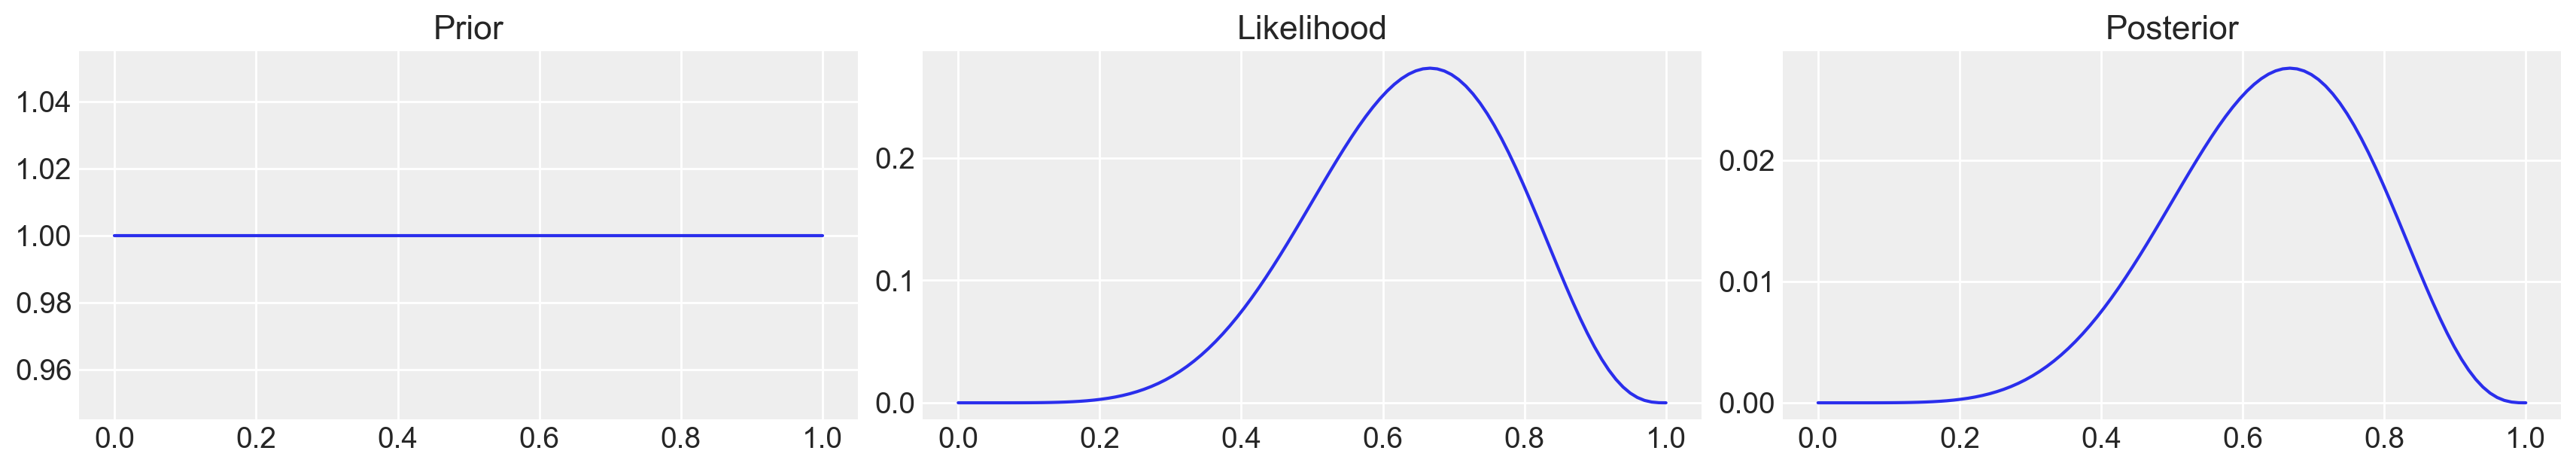

In [5]:
prior1 = np.repeat(1, grid_points)
posterior1 = computePosterior(likelihood, prior1)

Come previsto, in questo caso la distribuzione a posteriori sarà uguale alla distribuzione di verosimiglianza (a parte un fattore di scala), poiché non abbiamo fornito alcuna informazione aggiuntiva. Tuttavia, è interessante notare che la distribuzione uniforme è un caso particolare della distribuzione beta, con parametri $\alpha = 1$ e $\beta = 1$. Questo significa che la distribuzione uniforme è coniugata alla distribuzione binomiale.

Il secondo priore proposto è una funzione a gradino (step function). Questa distribuzione a priori rappresenta la convinzione che l'esito "testa" sia più probabile dell'esito "croce", ovvero che la moneta sia truccata in favore della testa, ma senza specificare di quanto. Per esprimere questa credenza, possiamo definire una funzione a gradino in cui la probabilità è 0 al di sotto di un certo valore e uniforme al di sopra.

La distribuzione a priori può essere definita come segue:

$$
p(\theta) = \begin{cases}
0, & \text{se } \theta < \theta_0 \\
c, & \text{se } \theta \geq \theta_0
\end{cases}
$$

dove:

* $\theta$ rappresenta la probabilità di ottenere "testa".
* $\theta_0$ è il valore di soglia al di sotto del quale la probabilità è 0.
* $c$ è una costante di normalizzazione per garantire che l'integrale della distribuzione sia uguale a 1.

Questa distribuzione a priori esprime la convinzione che la probabilità di ottenere "testa" sia maggiore di $\theta_0$ (nel caso presente, $\theta_0 = 0.5$). Tuttavia, non fornisce informazioni specifiche sulla distribuzione di probabilità al di sopra di $\theta_0$, assumendo semplicemente una distribuzione uniforme.

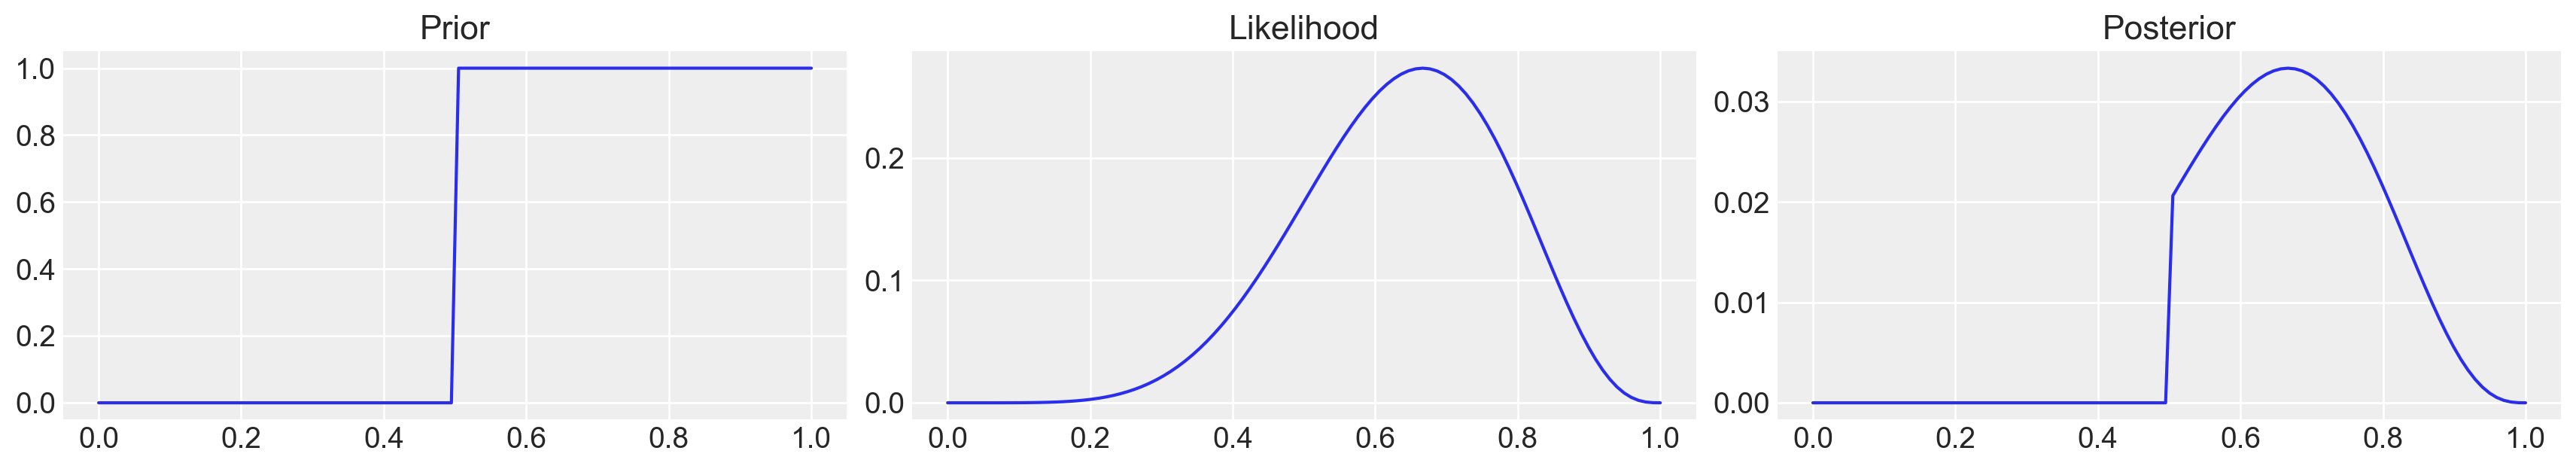

In [6]:
prior2 = (p_grid >= 0.5).astype(int)
posterior2 = computePosterior(likelihood, prior2)

La scelta di questo priore ha l'effetto di escludere completamente dalla distribuzione a posteriori tutti i valori di $\theta$ inferiori a $\theta_0$, assegnando loro una probabilità nulla. In pratica, questa scelta significa che siamo assolutamente certi che la probabilità di ottenere 'testa' sia superiore a $\theta_0$, escludendo completamente la possibilità di valori inferiori.

Il terzo prior che consideriamo è una distribuzione centrata su 0.5, con un rapido decadimento esponenziale su entrambi i lati. Anche questo caso rappresenta un prior coniugato, modellato da una distribuzione Beta con parametri $\alpha$ e $\beta$ uguali. Il carattere esponenziale della distribuzione esprime una riduzione relativamente veloce della densità di probabilità man mano che ci si allontana da 0.5. Ci possiamo aspettare che la scelta di questo priore abbia l'effetto di 'attrarre' la distribuzione a posteriori verso 0.5, a meno che i dati non forniscano evidenze contrarie molto forti.

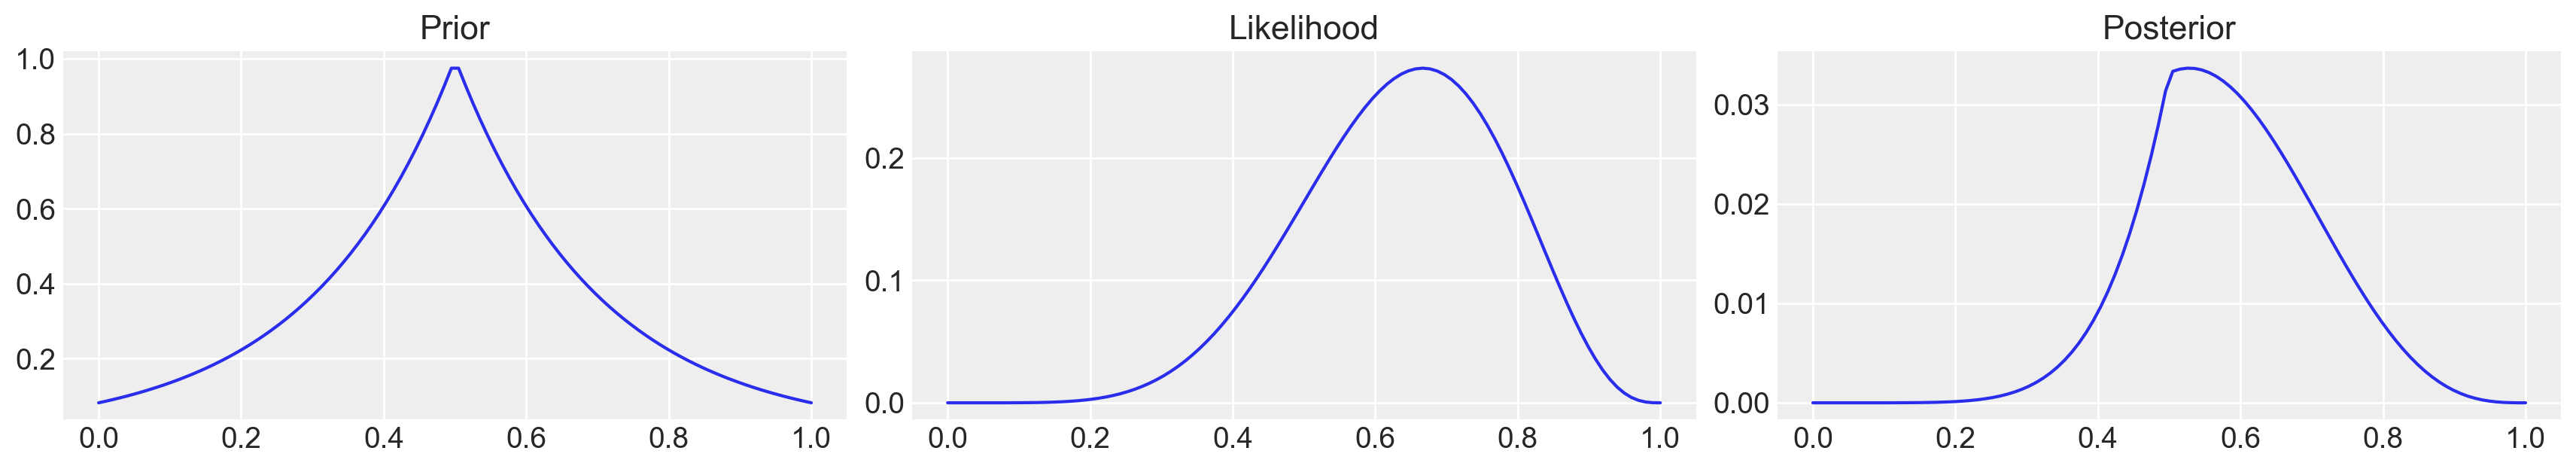

In [7]:
prior3 = np.exp(-5 * abs(p_grid - 0.5))
posterior3 = computePosterior(likelihood, prior3)

La distribuzione a posteriori conferma quanto previsto.

In una seconda serie di simulazioni, per illustrare l'importanza del priore, utilizzeremo le funzioni `plot_beta_binomial` e `summarize_beta_binomial` ispirate da @Johnson2022bayesrules. Ci concentreremo sul modello coniugato beta-binomiale. 

In [3]:
def plot_beta_binomial(alpha, beta, y=None, n=None, prior=True, likelihood=True, posterior=True) -> None:
    """Plot a Beta-Binomial Bayesian Model
    
    Parameters:
    - alpha, beta: positive shape parameters of the prior Beta distribution
    - y: observed number of successes
    - n: observed number of trials
    - prior: indicates whether the prior distribution should be plotted
    - likelihood: indicates whether the scaled likelihood should be plotted
    - posterior: indicates whether the posterior distribution should be plotted
    """
    
    θ = np.linspace(0, 1, 100)  # Range of possible values for θ
    
    if prior:
        p_theta = stats.beta.pdf(θ, alpha, beta)
        plt.fill_between(θ, p_theta, step='mid', alpha=0.2, color='blue', label='Prior')
    
    if y is not None and n is not None:
        if likelihood:
            likelihood_values = stats.binom.pmf(y, n, θ)
            scale_factor = integrate.simpson(y=likelihood_values, x=θ)  # Corrected to use keyword arguments
            plt.plot(θ, likelihood_values / scale_factor, color='orange', label='Likelihood (scaled)', lw=2)
        
        if posterior:
            alpha_post = alpha + y
            beta_post = beta + n - y
            p_theta_post = stats.beta.pdf(θ, alpha_post, beta_post)
            plt.fill_between(θ, p_theta_post, step='mid', alpha=0.4, color='green', label='Posterior')
    
    plt.xlabel(r'$\theta$')
    plt.ylabel('Density')
    plt.legend(loc='upper left')
    plt.title('Beta-Binomial Model')
    plt.show()


def summarize_beta_binomial(alpha, beta, y=None, n=None):
    """Summarize a Beta-Binomial Bayesian model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y number of successes
    @param n number of trials

    Return: Pandas dataframe summarizing beta binomial
    """

    def beta_mean(a, b):
        return a / (a + b)

    def beta_mode(a, b):
        if a < 1 and b < 1:
            return "0 and 1"
        elif a <= 1 and b > 1:
            return 0
        elif a > 1 and b < 1:
            return 1
        else:
            return (a - 1) / (a + b - 2)

    def beta_var(a, b):
        return a * b / ((a + b) ** 2 * (a + b + 1))

    prior_mean = beta_mean(alpha, beta)
    prior_mode = beta_mode(alpha, beta)
    prior_var = beta_var(alpha, beta)
    prior_sd = np.sqrt(prior_var)
    if y is None and n is None:
        summary = pd.DataFrame(
            {
                "alpha": alpha,
                "beta": beta,
                "mean": prior_mean,
                "mode": prior_mode,
                "var": prior_var,
                "sd": prior_sd,
            },
            index=["prior"],
        )
    else:
        post_alpha = y + alpha
        post_beta = n - y + beta
        post_mean = beta_mean(post_alpha, post_beta)
        post_mode = beta_mode(post_alpha, post_beta)
        post_var = beta_var(post_alpha, post_beta)
        post_sd = np.sqrt(post_var)
        summary = pd.DataFrame(
            {
                "alpha": [alpha, post_alpha],
                "beta": [beta, post_beta],
                "mean": [prior_mean, post_mean],
                "mode": [prior_mode, post_mode],
                "var": [prior_var, post_var],
                "sd": [prior_sd, post_sd],
            },
            index=["prior", "posterior"],
        )
    return summary

Nel caso in cui disponiamo di un campione di dati di dimensioni molto ridotte, come ad esempio 15 successi su 20 tentativi in una distribuzione beta-binomiale, la distribuzione a priori può esercitare un notevole impatto sulla distribuzione a posteriori. In contrasto, se consideriamo una distribuzione a priori uniforme, la distribuzione a posteriori assomiglierà alla funzione di verosimiglianza, con l'eccezione dell'area sotto le due curve. In parole più semplici, quando la distribuzione a priori è uniforme, la distribuzione a posteriori presenterà un picco nella stima di massima verosimiglianza. Tuttavia, quando adottiamo diverse distribuzioni a priori, la distribuzione a posteriori potrebbe notevolmente discostarsi.

Cominciamo esaminando il caso in cui viene adottata una distribuzione a priori uniforme.

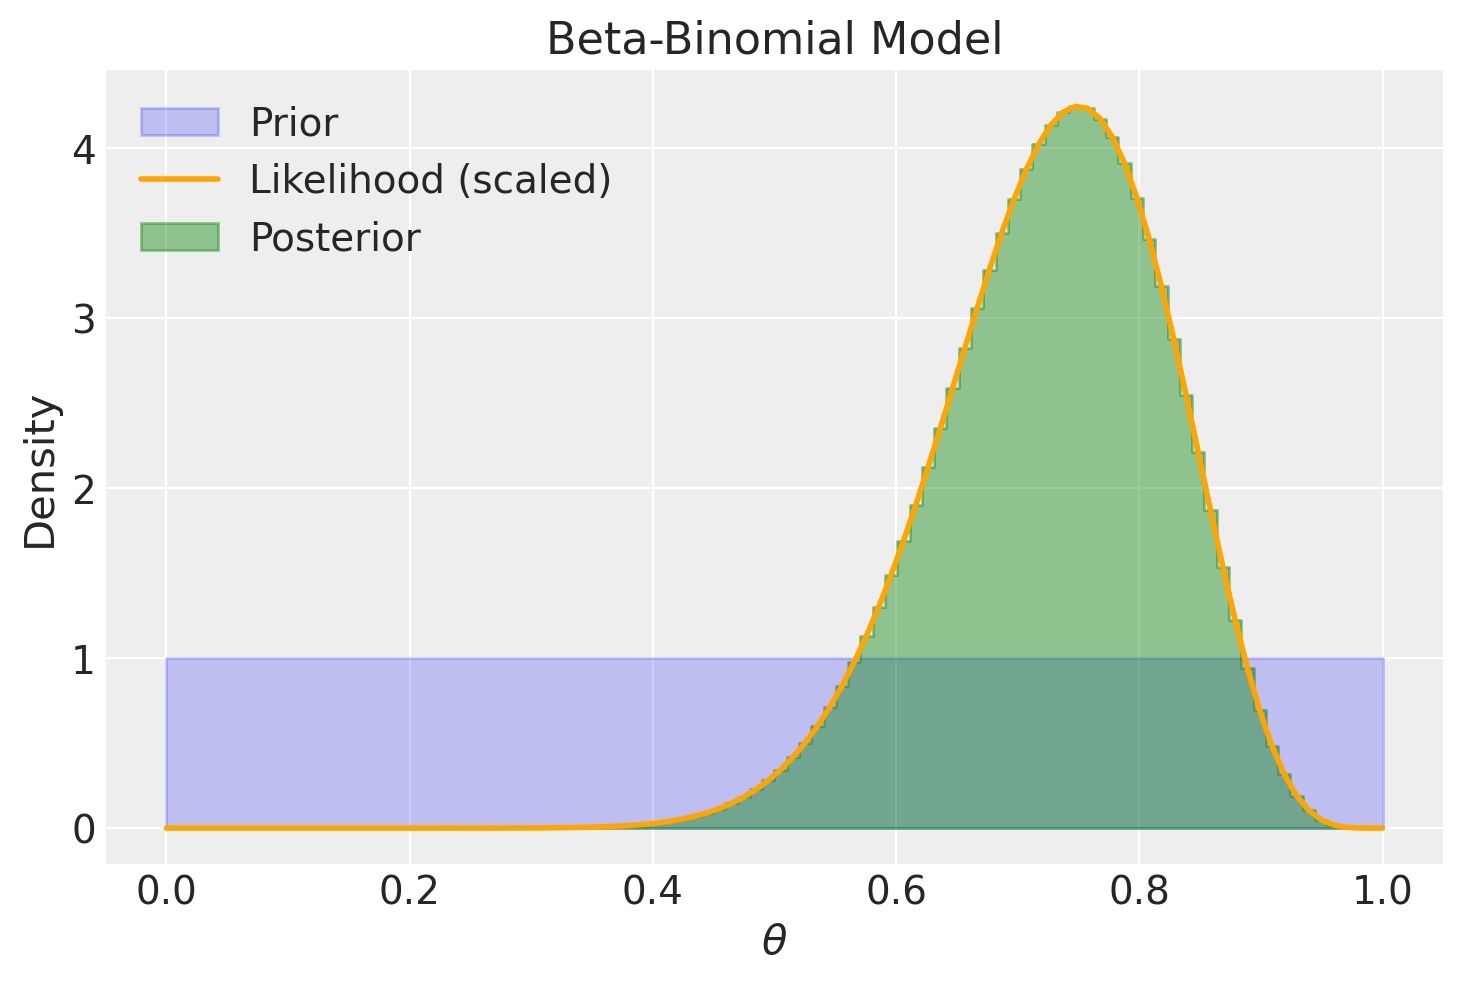

In [4]:
plot_beta_binomial(alpha=1, beta=1, y=15, n=20)

Esaminiamo ora l'effetto di una distribuzione a priori poco informativa, come ad esempio una Beta(2, 2). In questa situazione, l'impatto di tale scelta sulla distribuzione a posteriori è di modesta entità, ma comunque presente. Questo fenomeno può essere interpretato come un effetto di "regolarizzazione", il quale influisce sulla nostra stima in modo più cauto rispetto a quanto ottenuto tramite il principio di massima verosimiglianza. In altre parole, la stima risultante risulta essere più "bilanciata" verso il valore intermedio di 0.5.

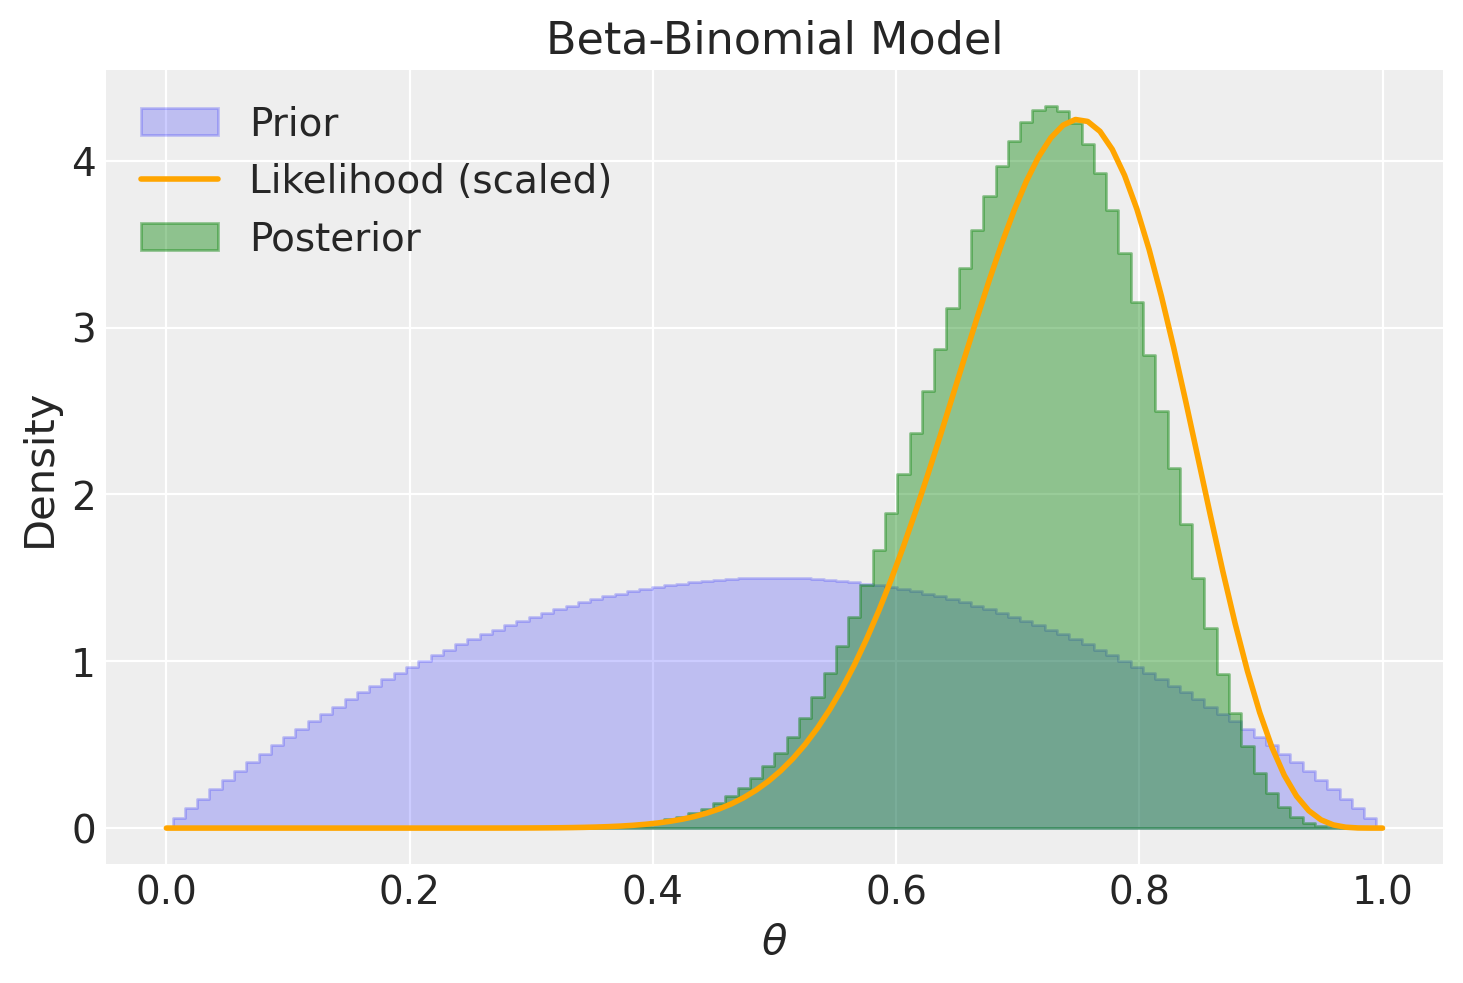

In [5]:
plot_beta_binomial(alpha=2, beta=2, y=15, n=20)

In [6]:
summarize_beta_binomial(alpha=2, beta=2, y=15, n=20)

,alpha,beta,mean,mode,var,sd
prior,2,2,0.500000,0.500000,0.050000,0.223607
posterior,17,7,0.708333,0.727273,0.008264,0.090906


Se il campione è di dimensioni maggiori, l'adozione di una distribuzione a priori Beta(2, 2) ha un effetto trascurabile: infatti, il valore massimo della distribuzione a posteriori risulta essere quasi identico alla stima di massima verosimiglianza.

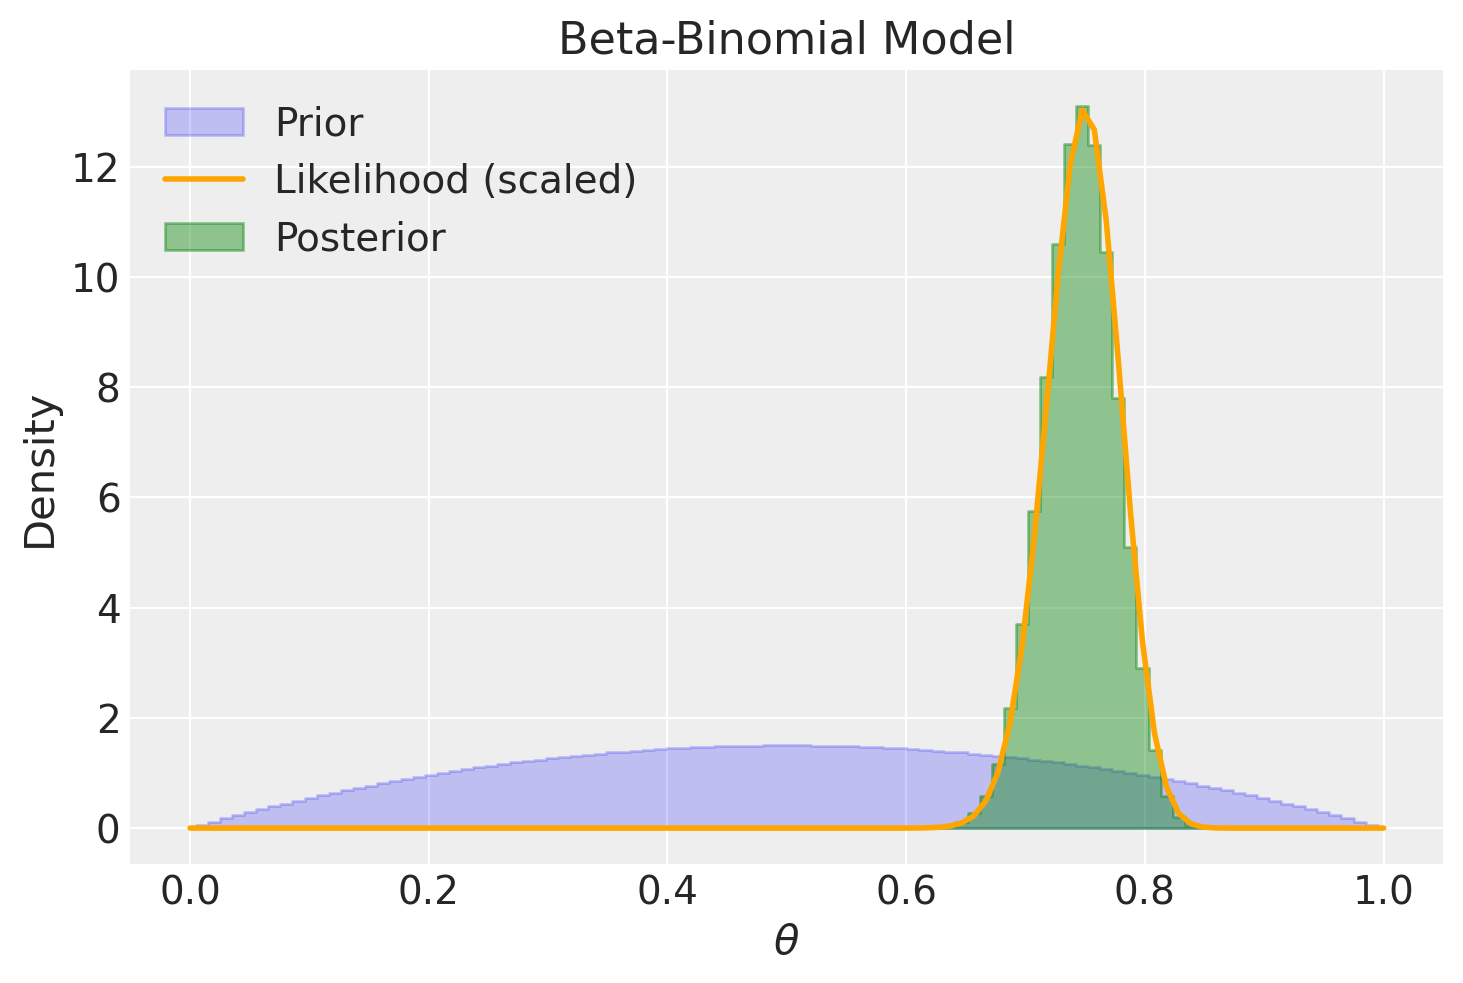

In [7]:
plot_beta_binomial(alpha=2, beta=2, y=150, n=200)

In [8]:
summarize_beta_binomial(alpha=2, beta=2, y=150, n=200)

,alpha,beta,mean,mode,var,sd
prior,2,2,0.500000,0.500000,0.050000,0.223607
posterior,152,52,0.745098,0.747525,0.000926,0.030438


Se optiamo per una distribuzione a priori informativa, questa avrà un notevole impatto sulla distribuzione a posteriori quando ci si trova di fronte a un campione di dimensioni ridotte.

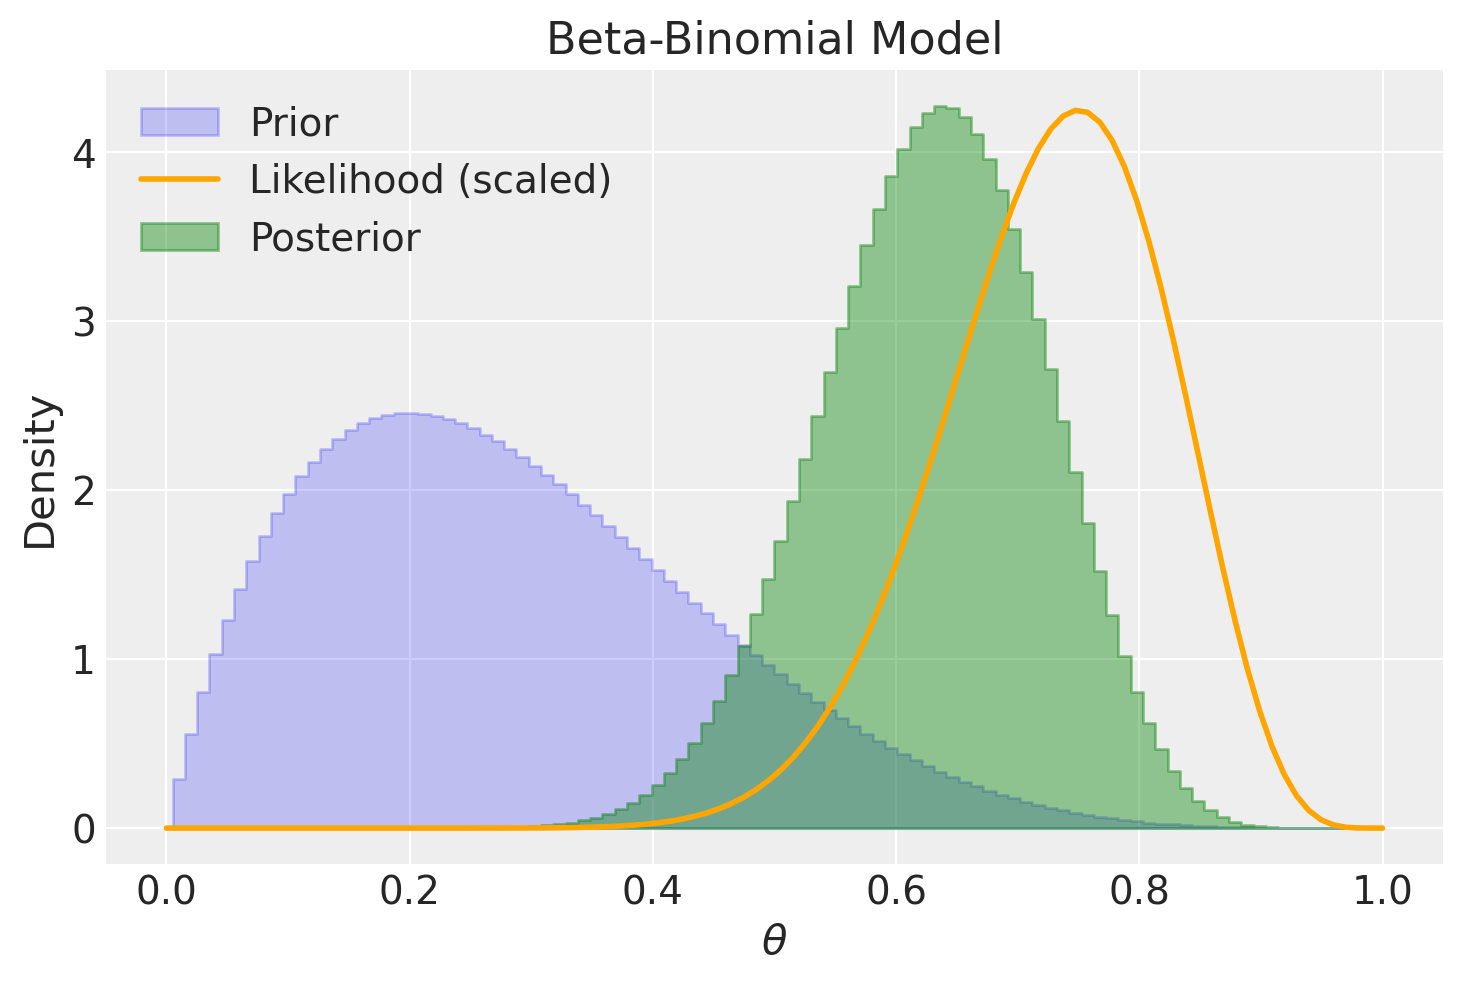

In [9]:
plot_beta_binomial(alpha=2, beta=5, y=15, n=20)

In [10]:
summarize_beta_binomial(alpha=2, beta=5, y=15, n=20)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.20,0.025510,0.159719
posterior,17,10,0.629630,0.64,0.008328,0.091260


Al contrario, la medesima distribuzione a priori ha un effetto insignificante sulla distribuzione a posteriori quando il campione è di dimensioni considerevoli.

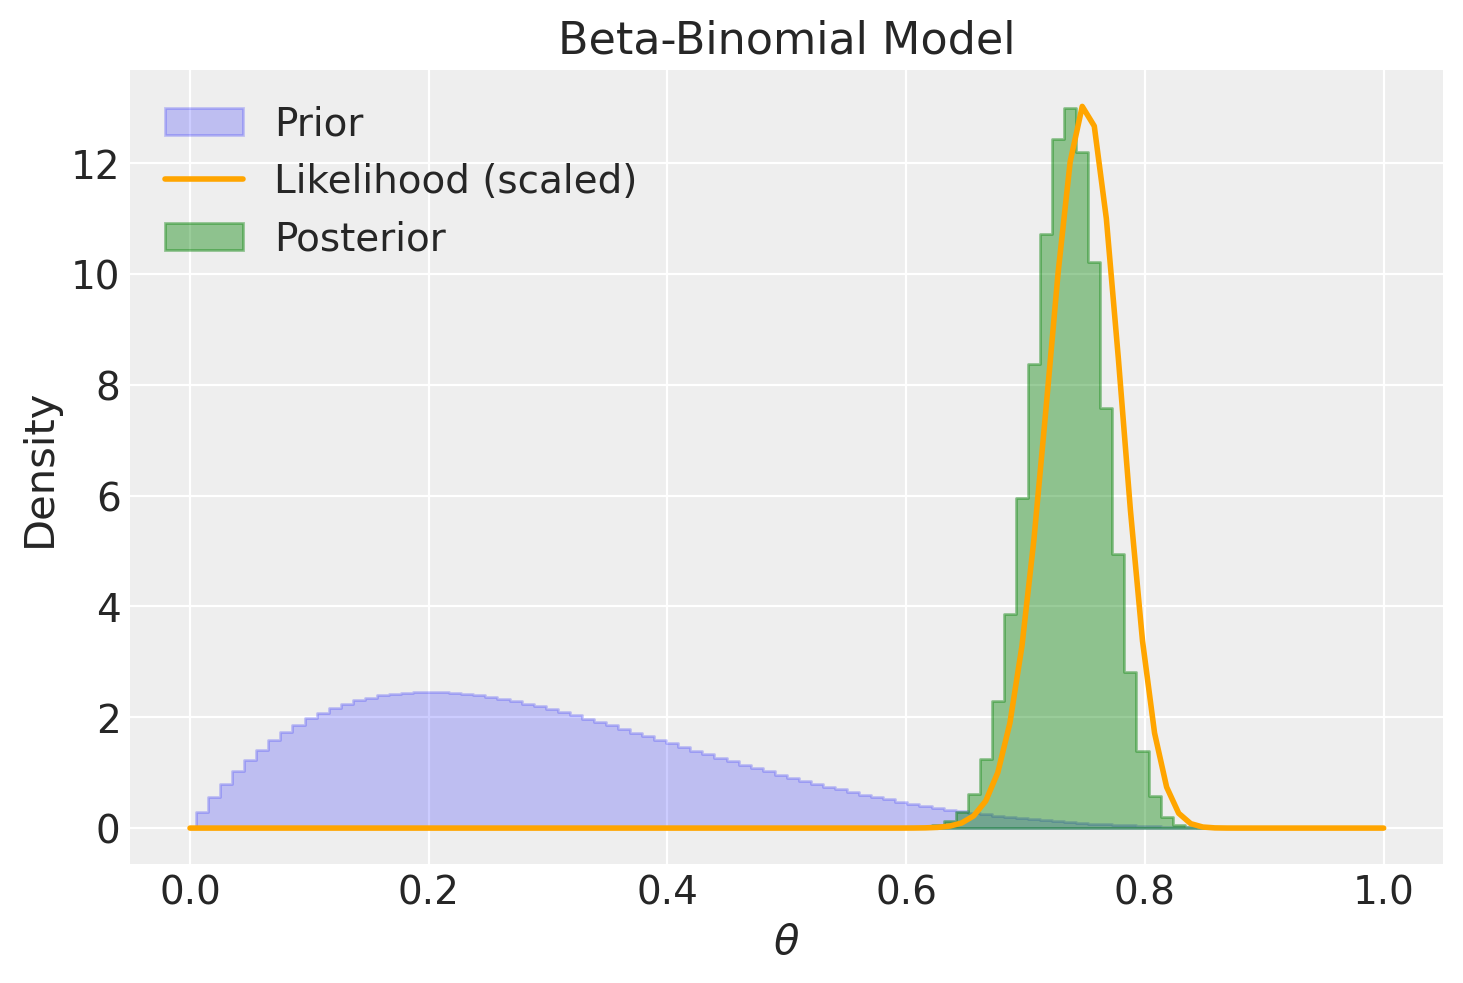

In [11]:
plot_beta_binomial(alpha=2, beta=5, y=150, n=200)

In [12]:
summarize_beta_binomial(alpha=2, beta=5, y=150, n=200)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.200000,0.025510,0.159719
posterior,152,55,0.734300,0.736585,0.000938,0.030627


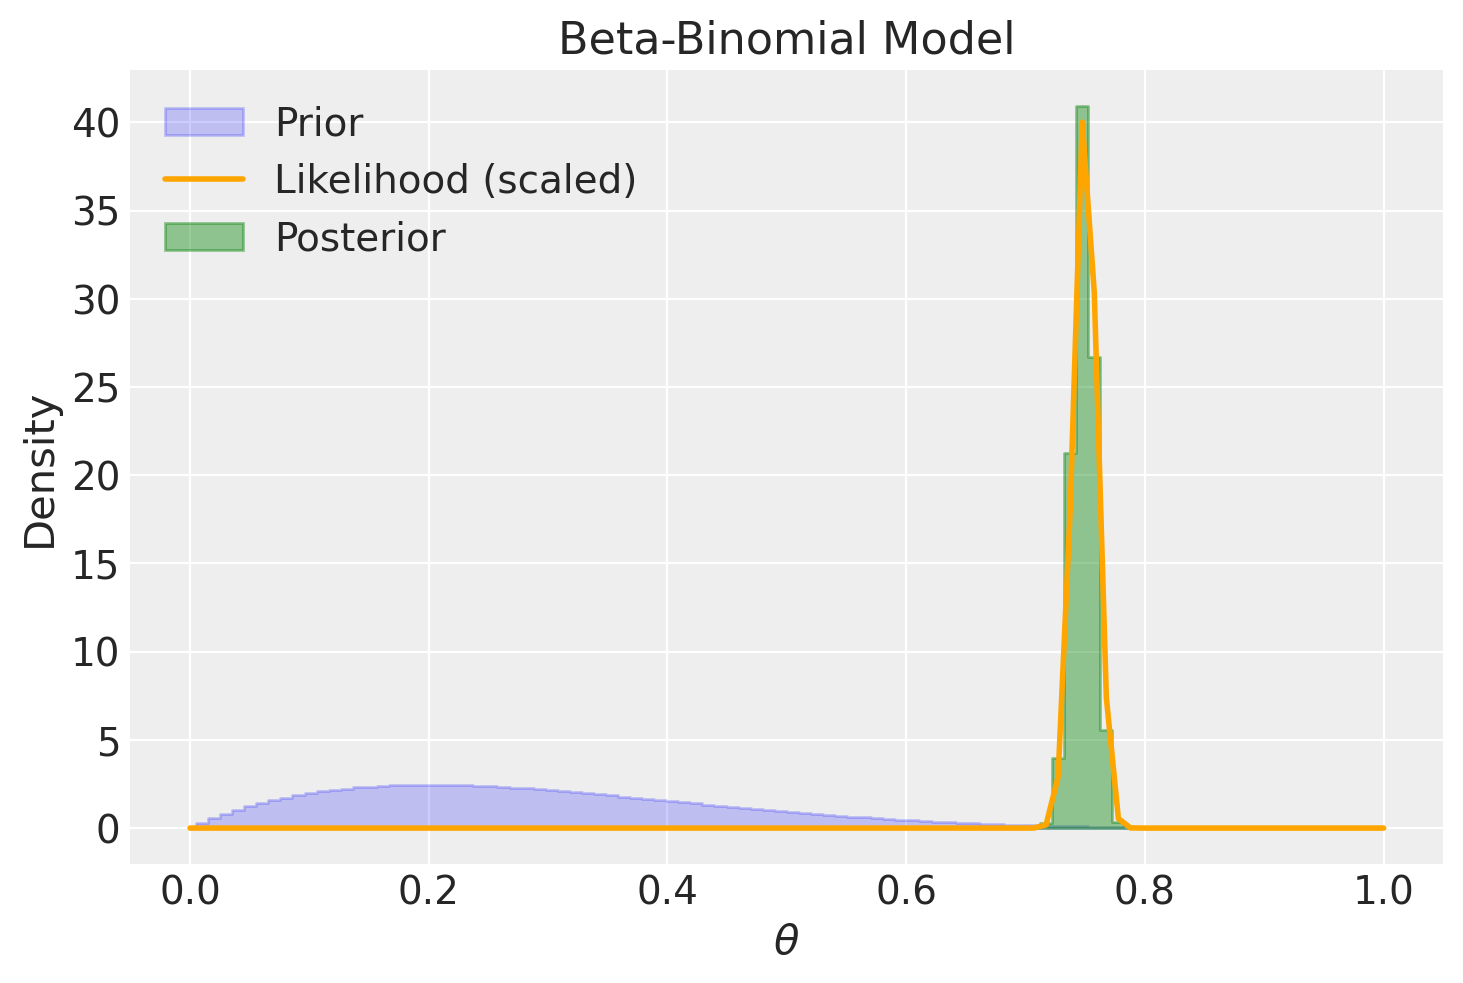

In [13]:
plot_beta_binomial(alpha=2, beta=5, y=1500, n=2000)

In [14]:
summarize_beta_binomial(alpha=2, beta=5, y=1500, n=2000)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.200000,0.025510,0.159719
posterior,1502,505,0.748381,0.748628,0.000094,0.009684


## Connessione tra intuizioni e teoria

L'equilibrio tra la distribuzione a priori e le evidenze provenienti dai dati, come dimostrato negli esempi precedenti, non solo rispecchia le nostre intuizioni, ma rappresenta anche una necessità matematica. Questo concetto diventa chiaro esaminando la formula del valore atteso della distribuzione a posteriori nel contesto del caso beta-binomiale, che può essere riscritta come segue:

$$
\begin{align}
\mathbb{E}_{\text{post}} &[\text{Beta}(\alpha + y, \beta + n - y)] = \frac{\alpha + y}{\alpha + \beta + n} \\
&= \frac{a+b}{a+b+n} \cdot \frac{a}{a+b} + \frac{n}{a+b+n} \cdot \frac{y}{n}.
\end{align}
$$ 

L'equazione precedente rivela che il valore atteso a posteriori si ottiene come una media ponderata tra il valore atteso a priori $\left( \frac{\alpha}{\alpha+\beta}\right)$ e la proporzione osservata dei successi $\left(\frac{y}{n}\right)$. I pesi sono dati da $\left( \frac{\alpha+\beta}{\alpha+\beta+n}\right)$ e $\left( \frac{n}{\alpha+\beta+n}\right)$. Pertanto, quando il numero di osservazioni $n$ è significativo rispetto alla somma dei parametri $\alpha + \beta$, la distribuzione a posteriori sarà principalmente influenzata dai dati osservati e in minor misura dalle credenze a priori. Al contrario, se $n$ è piccolo rispetto a $\alpha + \beta$, i dati avranno un peso inferiore rispetto alle credenze a priori.

Queste considerazioni indicano come scegliere i parametri $\alpha$ e $\beta$: se desideriamo rappresentare una totale ignoranza sul fenomeno, una scelta coerente è $\alpha = \beta = 1$ (attribuiamo uguale credibilità a ogni valore di $\theta$). Se, invece, possediamo forti credenze a priori, possiamo selezionare $\alpha$ in modo da eguagliare il valore atteso a priori, mentre $\alpha + \beta$ rifletterà l'importanza attribuita all'informazione a priori: maggiore è il valore di $\alpha + \beta$, maggiore sarà il numero di dati necessari per influenzare significativamente la distribuzione a posteriori rispetto a quella a priori. In situazioni in cui $n$ è considerevolmente grande, la distribuzione a posteriori avrà un impatto ridotto sulla distribuzione a priori, a meno che non si facciano scelte estreme per i parametri a priori.

## Conflitto tra Prior e Verosimiglianza

Esaminiamo ora un altro esempio proposto da McElreath:

> Lesson: Don't trust intuition, for even simple prior+likelihood scenarios defy it. Four examples below, each producing radically different posteriors. Can you guess what each does?

![](../../figures/mcelreath_post_1.png){width="80%"}

Nella figura successiva vediamo la risposta alla domanda precedente.

![](../../figures/mcelreath_post_2.png){width="80%"}

McElreath descrive le caratteristiche di quattro diversi modelli in cui si combinano distribuzioni normali (Gaussiane) e Student-t (con 2 gradi di libertà) per il prior e la likelihood. La distribuzione gaussiana ha code molto sottili, mentre quella di Student-t ha code più spesse.

1. **In Alto a Sinistra: Prior Normale, Likelihood Normale**

   - `y ~ Normal(mu,1)`
   - `mu ~ Normal(10,1)`

   In questo scenario classico di aggiornamento bayesiano, il posterior risulta essere un compromesso tra il prior e la likelihood. La distribuzione normale, con le sue code sottili, contribuisce a un aggiornamento più "prevedibile" e concentrato attorno al valore medio.

2. **In Alto a Destra: Prior Student, Likelihood Student (df=2)**

   - `y ~ Student(2,mu,1)`
   - `mu ~ Student(2,10,1)`

   In questo caso, entrambe le distribuzioni hanno code più spesse. La presenza di "extra massa" nelle code significa che ciascuna distribuzione trova il modo dell'altra più plausibile, portando a una media che non rappresenta il miglior "compromesso". Questo scenario risulta in una maggiore incertezza e un posterior meno definito.

3. **In Basso a Sinistra: Prior Student, Likelihood Normale**

   - `y ~ Normal(mu,1)`
   - `mu ~ Student(2,10,1)`

   Qui, la likelihood normale, con le sue code sottili, tende a dominare. Essa è molto scettica nei confronti del prior con code spesse, ma il prior di Student-t non è sorpreso dalla likelihood. Questo porta a un posterior che è più influenzato dalla likelihood normale.

4. **In Basso a Destra: Prior Normale, Likelihood Student**

   - `y ~ Student(2,mu,1)`
   - `mu ~ Normal(10,1)`
   
   In questo ultimo scenario, è il prior normale a dominare. Il ragionamento è simile a quello del caso precedente, ma in senso inverso. Il prior normale, con le sue code sottili, impone una maggiore influenza sul posterior, rendendolo meno influenzato dalle code più spesse della likelihood di Student-t.

In sintesi, la combinazione di queste due distribuzioni in diversi modi porta a risultati di aggiornamento bayesiano molto differenti, a seconda di quale tra prior e likelihood abbia le code più spesse e quindi eserciti una maggiore influenza sul posterior.

Di seguito è riportato il codice per riprodurre i risultati delle figure precedenti.

In [15]:
# Observed data
yobs = 0

# Number of samples
n_samples = 2000

# Model with normal prior and normal likelihood
with pm.Model() as mnn:
    mu = pm.Normal('mu', mu=10, sigma=1)
    y = pm.Normal('y', mu=mu, sigma=1, observed=yobs)
    trace_mnn = pm.sampling_jax.sample_numpyro_nuts(n_samples, chains=4)

# Model with t prior and t likelihood
with pm.Model() as mtt:
    mu = pm.StudentT('mu', nu=2, mu=10, sigma=1)
    y = pm.StudentT('y', nu=2, mu=mu, sigma=1, observed=yobs)
    trace_mtt = pm.sampling_jax.sample_numpyro_nuts(n_samples, chains=4)

# Model with t prior and normal likelihood
with pm.Model() as mnt:
    mu = pm.StudentT('mu', nu=2, mu=10, sigma=1)
    y = pm.Normal('y', mu=mu, sigma=1, observed=yobs)
    trace_mnt = pm.sampling_jax.sample_numpyro_nuts(n_samples, chains=4)

# Model with normal prior and t likelihood
with pm.Model() as mtn:
    mu = pm.Normal('mu', mu=10, sigma=1)
    y = pm.StudentT('y', nu=2, mu=mu, sigma=1, observed=yobs)
    trace_mtn = pm.sampling_jax.sample_numpyro_nuts(n_samples, chains=4)

Compiling...


Compilation time = 0:00:01.545217
Sampling...
Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/3000 [00:02<?, ?it/s]

Running chain 3: 100%|██████████| 3000/3000 [00:02<00:00, 1312.27it/s]
Sampling time = 0:00:02.652808
Transforming variables...
Transformation time = 0:00:00.099841
Compiling...
Compilation time = 0:00:00.571719
Sampling...
Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 3000/3000 [00:01<00:00, 1591.21it/s]
Sampling time = 0:00:01.982962
Transforming variables...
Transformation time = 0:00:00.053744
Compiling...
Compilation time = 0:00:00.421561
Sampling...
Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/3000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 3000/3000 [00:01<00:00, 1734.54it/s]
Sampling time = 0:00:01.823367
Transforming variables...
Transformation time = 0:00:00.049707
Compiling...
Compilation time = 0:00:00

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_61930/765634110.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


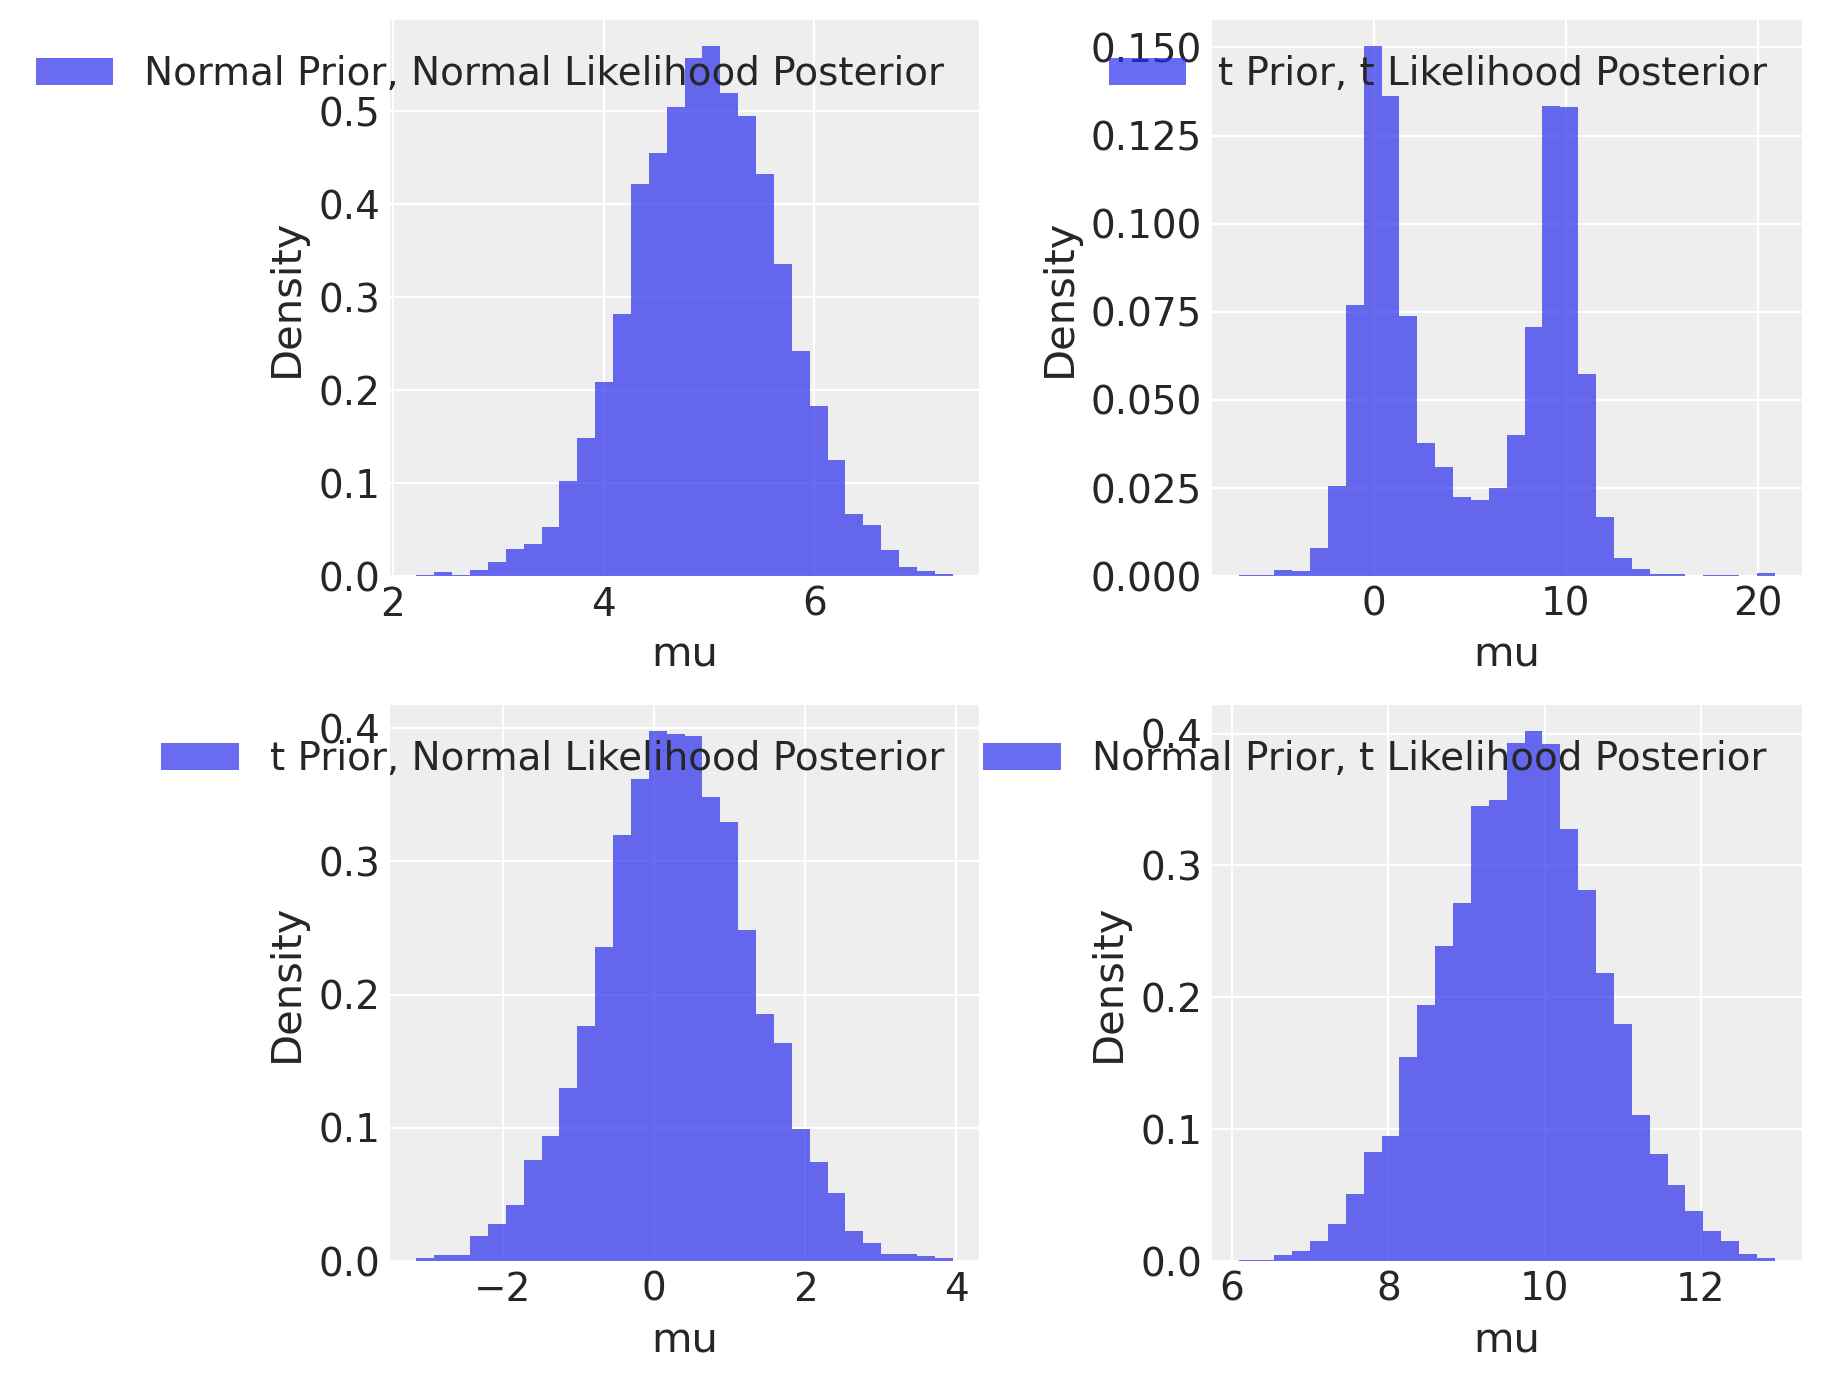

In [16]:
# Function to plot the results
def plot_posterior(trace, model_name):
    mu_samples = trace.posterior['mu'].values.flatten()  # Extracting 'mu' samples
    plt.hist(mu_samples, density=True, bins=30, alpha=0.7, label=f'{model_name} Posterior')
    plt.xlabel('mu')
    plt.ylabel('Density')
    plt.legend()

# Plotting the results
plt.figure(figsize=(9, 7))

plt.subplot(2, 2, 1)
plot_posterior(trace_mnn, 'Normal Prior, Normal Likelihood')

plt.subplot(2, 2, 2)
plot_posterior(trace_mtt, 't Prior, t Likelihood')

plt.subplot(2, 2, 3)
plot_posterior(trace_mnt, 't Prior, Normal Likelihood')

plt.subplot(2, 2, 4)
plot_posterior(trace_mtn, 'Normal Prior, t Likelihood')
plt.tight_layout()
plt.show()

In conclusione, questo esercizio mostra come, ad eccezione del caso gaussiano, i risultati non sono affatto intuitivi. Pertanto, in contesti come questi, affidarsi esclusivamente alle proprie intuizioni non è una scelta consigliabile. È invece fondamentale procedere con l'esecuzione dei calcoli.

## Riflessioni Conclusive

La scelta della distribuzione a priori è uno degli aspetti più cruciali nell'inferenza bayesiana. Da un lato, le priors non informative possono essere utilizzate per minimizzare l'influenza delle conoscenze pregresse, permettendo ai dati osservati di guidare l'inferenza. Dall'altro, le priors informative sono estremamente utili quando si dispone di informazioni affidabili sui parametri, consentendo una stima più precisa. È importante ricordare che, con un gran numero di dati, l'influenza della prior tende a ridursi, mentre nei contesti con pochi dati la scelta della prior può avere un impatto significativo.

Un aspetto essenziale dell'approccio bayesiano, come evidenziato nell'esempio di Johnson (2022), è che il processo di aggiornamento bayesiano riflette il modo in cui le persone ragionano intuitivamente: di fronte a evidenze deboli, le credenze rimangono stabili, mentre nuove informazioni robuste portano a un aggiornamento significativo delle credenze. Questo meccanismo formalizza in modo quantitativo e rigoroso le intuizioni che utilizziamo quotidianamente. Al contrario, l'approccio frequentista ignora le conoscenze pregresse, il che può portare a cambiamenti nelle inferenze senza tener conto delle credenze già esistenti.

Tuttavia, come evidenziato dagli esempi di McElreath, la situazione può essere più complessa nei modelli non coniugati, dove l'intuizione può fallire nel prevedere correttamente la distribuzione a posteriori. Questo ci ricorda che il contesto e la struttura del modello giocano un ruolo determinante nell'inferenza bayesiana.

### Il Ruolo della Prior nella Regolarizzazione

Nel contesto bayesiano, le distribuzioni a priori debolmente informative fungono da meccanismo di regolarizzazione, limitando l'influenza delle osservazioni estreme e garantendo inferenze più stabili. Questo approccio è ormai ampiamente accettato nella comunità statistica, poiché permette di ottenere risultati più prudenti senza introdurre un forte bias.

### L'Importanza dei Prior Informativi

Negli ultimi anni, l'uso di priori informativi ha guadagnato maggiore attenzione, soprattutto grazie all'integrazione delle *conoscenze esperte* nel processo inferenziale. Questa pratica, nota come <font color='orange'>elicitazione della conoscenza esperta</font>, richiede un rigoroso approccio metodologico per evitare bias cognitivi e assicurare che le informazioni pregresse siano incorporate in modo accurato. Questo è particolarmente rilevante in campi come la psicologia, dove spesso la base teorica è incerta, e l'elicitazione esperta può contribuire a migliorare la solidità delle analisi bayesiane [@o2019expert].

### Conclusioni Finali

In conclusione, [la scelta delle prior](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) deve essere ponderata attentamente in base alla disponibilità di dati e al contesto dell'analisi. Sebbene l'uso di priors non informative possa sembrare una scelta "neutra", è spesso sub-ottimale. Le priors debolmente informative rappresentano lo standard attuale, poiché favoriscono un'inferenza più robusta grazie alla loro capacità di regolarizzare l'influenza dei dati. Infine, l'uso di priori informativi, sviluppati attraverso protocolli rigorosi di elicitazione esperta, è una frontiera in crescita nell'analisi bayesiana, poiché consente di sfruttare al meglio le conoscenze pregresse per migliorare la qualità delle inferenze e ridurre l'incertezza.

Questo approccio, che bilancia conoscenza pregressa e nuovi dati, permette di sviluppare modelli bayesiani più solidi e informati, riflettendo accuratamente sia l'incertezza sia la competenza specifica del dominio di studio.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p jax

Last updated: Tue Apr 09 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.1

jax: 0.4.25

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

arviz     : 0.17.0
requests  : 2.31.0
numpy     : 1.26.4
seaborn   : 0.13.2
scipy     : 1.12.0
pandas    : 2.2.1
pymc      : 5.10.4
matplotlib: 3.8.3

Watermark: 2.4.3

